## Generate Analysts: Human-In-The-Loop

In [17]:
import os
if "GOOGLE_API_KEY" not in os.environ:
        os.environ["GOOGLE_API_KEY"] = os.environ["GEMINI_API_KEY"]

# if "MISTRAL_API_KEY" not in os.environ:
#     os.environ["MISTRAL_API_KEY"] = os.environ["MISTRAL_API_KEY"]

from langchain_google_genai import ChatGoogleGenerativeAI
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash" ,temperature=0)
# llm_versatile = ChatGoogleGenerativeAI(model="gemma-3n-e4b-it" ,temperature=0.5)
# llm_versatile = ChatGoogleGenerativeAI(model="gemma-3-27b-it" ,temperature=0.5)
llm_versatile = ChatGoogleGenerativeAI(model="gemini-2.0-flash-lite" ,temperature=0.5)

from langchain_mistralai import ChatMistralAI
llm_creative = ChatMistralAI(model="mistral-small-2503", temperature=1)

# _set_env("LANGSMITH_API_KEY")
os.environ["LANGSMITH_TRACING"] = "true"
os.environ["LANGSMITH_PROJECT"] = "langchain-academy"



In [3]:
from typing import List, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from operator import add

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    # human_analyst_feedback: Annotated[List[str], add]  # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    # analysts: Annotated[List[Analyst], add] 
    # final_analysts: List[Analyst] #= Field(..., min_items=3, max_items=3, description="Exactly 3 related sub-topics")# Analyst asking questions

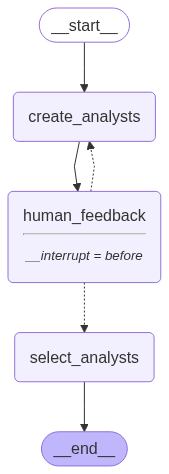

In [4]:
from IPython.display import Image, display
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

selector_instructions="""You are tasked with selecting {max_analysts} AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
{human_analyst_feedback}
    
3. Here are the candidates:
{candidates}
                    
4. Pick {max_analysts} analysts suitable for researching about {topic}. Make sure to select no more and no less than {max_analysts} analysts.
"""

def create_analysts(state: GenerateAnalystsState):
    
    """ Create analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    # human_analyst_feedback=state.get('human_analyst_feedback', '')
    # import pdb; pdb.set_trace()
    human_analyst_feedback=state.get('human_analyst_feedback', [])
    if human_analyst_feedback:
        human_analyst_feedback = human_analyst_feedback
    else:
        human_analyst_feedback = ""
                
    # Enforce structured output
    # structured_llm = llm.with_structured_output(Perspectives)
    structured_llm = llm_creative.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": analysts.analysts}

def select_analysts(state: GenerateAnalystsState):
    
    """ Select analysts """
    
    topic=state['topic']
    max_analysts=state['max_analysts']
    human_analyst_feedback=state.get('human_analyst_feedback', [])
    human_analyst_feedback = "\n".join(feedback for feedback in human_analyst_feedback if feedback)
    candidates = state.get('analysts', [])
    candidates = "\n\n".join(analyst.persona for analyst in candidates)
                
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = selector_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts,
                                                            candidates=candidates)

    # Generate question 
    analysts = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Pick the {max_analysts} analysts.")])
    
    # Write the list of analysis to state
    return {"final_analysts": analysts.analysts}

def human_feedback(state: GenerateAnalystsState):
    """ No-op node that should be interrupted on """
    pass

def should_continue(state: GenerateAnalystsState):
    """ Return the next node to execute """

    # Check if human feedback
    # human_analyst_feedback=state.get('human_analyst_feedback', [None])
    # if len(human_analyst_feedback) > 0:
    #     human_analyst_feedback = human_analyst_feedback[-1]
    # if human_analyst_feedback:
    #     return "create_analysts"
    # return "select_analysts"

    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    

# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("select_analysts", select_analysts)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", "select_analysts"])
builder.add_edge("select_analysts", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [5]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts,}, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

# graph.invoke({"topic":topic,"max_analysts":max_analysts,}, thread)

Name: Dr. Ada Sterling
Affiliation: Institute for Ethical AI
Role: AI Ethics Specialist
Description: Dr. Sterling focuses on the ethical implications of adopting LangGraph as an agent framework. She is concerned with ensuring that the technology is used responsibly and does not perpetuate biases or invade privacy. Her goal is to provide guidelines for ethical AI development and implementation.
--------------------------------------------------
Name: Prof. Leo Kim
Affiliation: Tech Innovations Lab
Role: AI Research Scientist
Description: Prof. Kim is interested in the technical benefits and challenges of LangGraph. He aims to evaluate the framework's performance, scalability, and integration capabilities. His research will provide insights into how LangGraph can enhance AI agent capabilities and drive innovation in the field.
--------------------------------------------------
Name: Ms. Clara Hart
Affiliation: Future Tech Insights
Role: AI Industry Analyst
Description: Ms. Hart analyzes 

In [6]:
# Get state and look at next node
state = graph.get_state(thread)
state.next

('human_feedback',)

In [7]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                            ["Add in someone from a startup to add an entrepreneur perspective"]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f040e17-ab88-6dde-8002-85717eff73f6'}}

In [8]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Ada Sterling
Affiliation: Institute for Ethical AI
Role: AI Ethics Specialist
Description: Dr. Sterling focuses on the ethical implications of adopting LangGraph as an agent framework. She is concerned with ensuring that the technology is used responsibly and does not perpetuate biases or invade privacy. Her goal is to provide guidelines for ethical AI development and implementation.
--------------------------------------------------
Name: Prof. Leo Kim
Affiliation: Tech Innovations Lab
Role: AI Research Scientist
Description: Prof. Kim is interested in the technical benefits and challenges of LangGraph. He aims to evaluate the framework's performance, scalability, and integration capabilities. His research will provide insights into how LangGraph can enhance AI agent capabilities and drive innovation in the field.
--------------------------------------------------
Name: Ms. Clara Hart
Affiliation: Future Tech Insights
Role: AI Industry Analyst
Description: Ms. Hart analyzes 

In [8]:
graph.update_state(thread, {"human_analyst_feedback": 
                            ["It would be great to have some perspective from the open source community"]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f03f578-8666-6be3-8004-84c3b6e05068'}}

In [9]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="updates"):
    # Review
    create_analysts = event.get('create_analysts', '')
    if create_analysts:
        analysts = create_analysts.get('analysts', [])
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)
    

Name: Alexandra 'Alex' Thompson
Affiliation: Open Source Initiative (OSI)
Role: Open Source Advocate
Description: Alex is deeply involved in the open-source community and is passionate about the adoption of open-source technologies in various industries. She is particularly interested in how LangGraph can benefit open-source projects by providing a robust framework for agent development. Alex is concerned about the sustainability and community support for LangGraph and wants to ensure that it remains accessible and inclusive.
--------------------------------------------------
Name: Dr. Jamie Lee
Affiliation: Stanford University
Role: AI Researcher
Description: Jamie is a leading researcher in the field of artificial intelligence and natural language processing. She is intrigued by the potential of LangGraph to revolutionize AI agent frameworks. Jamie's focus is on the technical capabilities and innovations that LangGraph brings to the table, as well as its potential to advance AI resea

In [9]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(thread, {"human_analyst_feedback": 
                            [further_feedack]}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f040e19-0e8f-6f7a-8004-a2d2a21e16a1'}}

In [10]:
# Continue the graph execution to end
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
create_analysts
--Node--
__interrupt__


In [11]:
final_state = graph.get_state(thread)
analysts = final_state.values.get('analysts')
final_analysts = final_state.values.get('final_analysts')

In [13]:
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Ada Sterling
Affiliation: Global Ethics Institute
Role: AI Ethics Specialist
Description: Dr. Sterling focuses on the ethical implications of adopting LangGraph as an agent framework. She is concerned about data privacy, bias, and the potential misuse of the technology. Her goal is to ensure that the adoption of LangGraph aligns with ethical standards and benefits society as a whole.
--------------------------------------------------
Name: Alex Taylor
Affiliation: Tech Innovators Inc.
Role: AI Integration Specialist
Description: Alex Taylor specializes in the integration of new AI technologies into existing systems. He is interested in the practical benefits of adopting LangGraph, such as improved efficiency, scalability, and the ability to handle complex data structures. Alex aims to provide insights into how LangGraph can be seamlessly integrated into various industries.
--------------------------------------------------
Name: Jamie Lee
Affiliation: Advanced AI Research Lab

In [14]:
print("Final Analysts:")
for analyst in final_analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50)

Final Analysts:
Name: Alex Taylor
Affiliation: Innovatech Labs
Role: AI Startup Founder
Description: Alex Taylor is passionate about leveraging LangGraph to drive innovation in startups. He is interested in how LangGraph can provide a competitive edge, streamline operations, and foster creativity within small, agile teams. He is also keen on the scalability and cost-effectiveness of the framework.
--------------------------------------------------
Name: Alexandra 'Alex' Thompson
Affiliation: Open Source Initiative (OSI)
Role: Open Source Advocate
Description: Alex is deeply involved in the open-source community and is passionate about the adoption of open-source technologies in various industries. She is particularly interested in how LangGraph can benefit open-source projects by providing a robust framework for agent development. Alex is concerned about the sustainability and community support for LangGraph and wants to ensure that it remains accessible and inclusive.
----------------

## Conduct Interview

### Generate Question

The analyst will ask questions to the expert.

In [12]:
import operator
from typing import  Annotated
from langgraph.graph import MessagesState

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(None, description="Search query for retrieval.")

In [18]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your bio, topic of focus, and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""

def generate_question(state: InterviewState):
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    if isinstance(messages[-1], AIMessage):
        # If the last message is from the AI, we need to add a human message
        messages.append(HumanMessage(content="Considering your expertise and prior responses, formulate an insightful follow-up question that delves deeper into the topic."))

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm_versatile.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

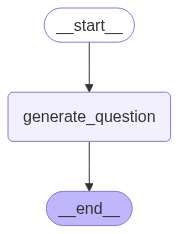

In [19]:
# Add nodes and edges 
builder = StateGraph(InterviewState)
builder.add_node("generate_question", generate_question)

builder.add_edge(START, "generate_question")
builder.add_edge("generate_question", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [20]:
thread = {"configurable": {"thread_id": "11"}}
# messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
messages = [HumanMessage(f"Based on your background, formulate an insightful question about the given topic: {topic}.")]
for event in graph.stream({"messages":messages, "analyst":analysts[0]}, thread, stream_mode="updates"):
    # Review
    print(event)  

{'generate_question': {'messages': [AIMessage(content="Hello Dr. Sterling, I'm Alex, a research analyst at the Institute. Given your expertise in AI ethics and governance, I'm particularly interested in understanding the ethical implications of adopting new AI frameworks. My question is: **While LangGraph offers benefits as an agent framework, what specific, unforeseen ethical challenges might arise from its adoption, and how can developers proactively address these challenges during the design and deployment phases?**", additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run--2e4bcccd-2fcc-45f5-86c1-a214c28ee369-0', usage_metadata={'input_tokens': 265, 'output_tokens': 86, 'total_tokens': 351, 'input_token_details': {'cache_read': 0}})]}}


### Generate Answer: Parallelization

In [21]:
# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
tavily_search = TavilySearchResults(max_results=3)

# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [22]:
import time
# Search query writing
search_instructions = SystemMessage(content=f"""You will be given a conversation between an analyst and an expert. 

Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.
        
First, analyze the full conversation.

Pay particular attention to the final question posed by the analyst.

Convert this final question into a well-structured web search query""")

def search_web(state: InterviewState):
    
    """ Retrieve docs from web search """
    time.sleep(5)
    # Search query
    messages = state["messages"]
    structured_llm = llm_creative.with_structured_output(SearchQuery)
    # search_query = structured_llm.invoke([search_instructions]+state['messages'])
    human_message = HumanMessage(content=messages[-1].content)
    search_query = structured_llm.invoke([search_instructions] + [human_message])
    
    # Search
    search_docs = tavily_search.invoke(search_query.search_query)

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """

    time.sleep(10)  # Simulate a delay for the search operation
    # Search query
    messages = state["messages"]
    structured_llm = llm.with_structured_output(SearchQuery)
    # search_query = structured_llm.invoke([search_instructions]+state['messages'])
    human_message = HumanMessage(content=messages[-1].content)
    search_query = structured_llm.invoke([search_instructions] + [human_message])
    
    # Search
    search_docs = WikipediaLoader(query=search_query.search_query, 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""

def generate_answer(state: InterviewState):
    
    """ Node to answer a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]
    context = state["context"]

    # Answer question
    system_message = answer_instructions.format(goals=analyst.persona, context=context)
    human_message = HumanMessage(content=messages[-1].content)
    answer = llm.invoke([SystemMessage(content=system_message)] + [human_message])
            
    # Name the message as coming from the expert
    answer.name = "expert"
    
    time.sleep(10)  # Simulate a delay for the answer generation
    # Append it to state
    return {"messages": [answer]}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"



In [23]:
from langchain_core.messages import get_buffer_string

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

In [24]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 400 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    time.sleep(10)  # Simulate a delay for the answer generation
    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}

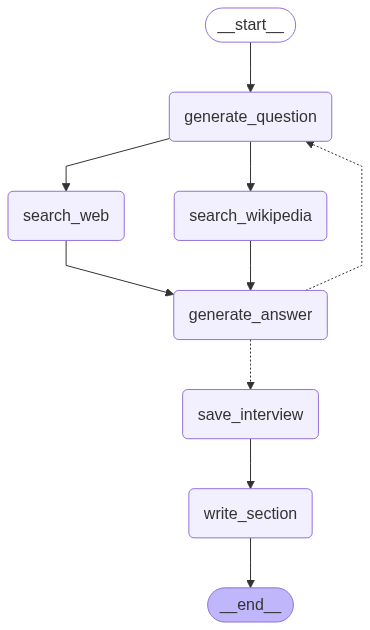

In [25]:
# Add nodes and edges 
builder = StateGraph(InterviewState)
builder.add_node("generate_question", generate_question)
builder.add_node("search_web", search_web)
builder.add_node("search_wikipedia", search_wikipedia)
builder.add_node("generate_answer", generate_answer)
builder.add_node("save_interview", save_interview)
builder.add_node("write_section", write_section)

builder.add_edge(START, "generate_question")
builder.add_edge("generate_question", "search_web")
builder.add_edge("generate_question", "search_wikipedia")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_wikipedia", "generate_answer")
builder.add_conditional_edges("generate_answer", route_messages, ['generate_question', 'save_interview'])
builder.add_edge("save_interview", "write_section")
builder.add_edge("write_section", END)
# builder.add_edge("generate_answer", END)

# Compile
graph = builder.compile()

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [26]:
thread = {"configurable": {"thread_id": "11"}}
# messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
messages = [HumanMessage(f"Based on your background, formulate an insightful question about the given topic: {topic}.")]
for event in graph.stream({"messages":messages, "analyst":final_analysts[0]}, thread, stream_mode="updates"):
    # Review
    print(event)
    print("----------------------------\n")

TypeError: 'NoneType' object is not subscriptable

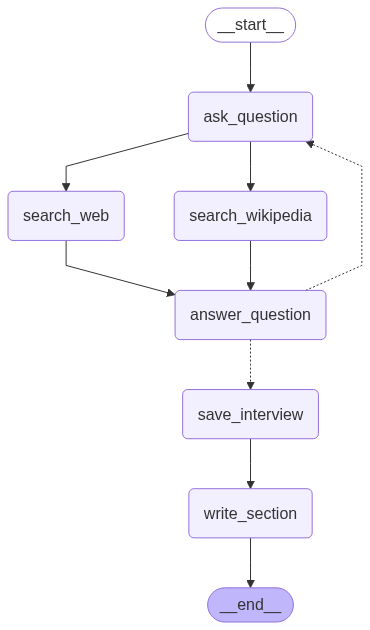

In [27]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("search_web", search_web)
interview_builder.add_node("search_wikipedia", search_wikipedia)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "search_web")
interview_builder.add_edge("ask_question", "search_wikipedia")
interview_builder.add_edge("search_web", "answer_question")
interview_builder.add_edge("search_wikipedia", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

### Parallelze interviews: Map-Reduce

We parallelize the interviews via the `Send()` API, a map step.

We combine them into the report body in a reduce step.

### Finalize

We add a final step to write an intro and conclusion to the final report.

In [28]:
import operator
from typing import List, Annotated
from typing_extensions import TypedDict

class ResearchGraphState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions
    sections: Annotated[list, operator.add] # Send() API key
    introduction: str # Introduction for the final report
    content: str # Content for the final report
    conclusion: str # Conclusion for the final report
    final_report: str # Final report

In [29]:
from langgraph.constants import Send

def initiate_all_interviews(state: ResearchGraphState):
    """ This is the "map" step where we run each interview sub-graph using Send API """    

    # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback')
    if human_analyst_feedback:
        # Return to create_analysts
        return "create_analysts"

    # Otherwise kick off interviews in parallel via Send() API
    else:
        topic = state["topic"]
        return [Send("conduct_interview", {"analyst": analyst,
                                           "messages": [HumanMessage(
                                               content=f"So you said you were writing an article on {topic}?"
                                           )
                                                       ]}) for analyst in state["analysts"]]

In [30]:
report_writer_instructions = """You are a technical writer creating a report on this overall topic: 

{topic}
    
You have a team of analysts. Each analyst has done two things: 

1. They conducted an interview with an expert on a specific sub-topic.
2. They write up their finding into a memo.

Your task: 

1. You will be given a collection of memos from your analysts.
2. Think carefully about the insights from each memo.
3. Consolidate these into a crisp overall summary that ties together the central ideas from all of the memos. 
4. Summarize the central points in each memo into a cohesive single narrative.

To format your report:
 
1. Use markdown formatting. 
2. Include no pre-amble for the report.
3. Use no sub-heading. 
4. Start your report with a single title header: ## Insights
5. Do not mention any analyst names in your report.
6. Preserve any citations in the memos, which will be annotated in brackets, for example [1] or [2].
7. Create a final, consolidated list of sources and add to a Sources section with the `## Sources` header.
8. List your sources in order and do not repeat.

[1] Source 1
[2] Source 2

Here are the memos from your analysts to build your report from: 

{context}"""

def write_report(state: ResearchGraphState):
    # Full set of sections
    time.sleep(10)  # Simulate a delay for the answer generation
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    system_message = report_writer_instructions.format(topic=topic, context=formatted_str_sections)    
    report = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Write a report based upon these memos.")]) 
    return {"content": report.content}

In [31]:
intro_conclusion_instructions = """You are a technical writer finishing a report on {topic}

You will be given all of the sections of the report.

You job is to write a crisp and compelling introduction or conclusion section.

The user will instruct you whether to write the introduction or conclusion.

Include no pre-amble for either section.

Target around 100 words, crisply previewing (for introduction) or recapping (for conclusion) all of the sections of the report.

Use markdown formatting. 

For your introduction, create a compelling title and use the # header for the title.

For your introduction, use ## Introduction as the section header. 

For your conclusion, use ## Conclusion as the section header.

Here are the sections to reflect on for writing: {formatted_str_sections}"""

def write_introduction(state: ResearchGraphState):
    time.sleep(15)  # Simulate a delay for the answer generation
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    intro = llm_creative.invoke([instructions]+[HumanMessage(content=f"Write the report introduction")]) 
    return {"introduction": intro.content}

def write_conclusion(state: ResearchGraphState):
    time.sleep(15)  # Simulate a delay for the answer generation
    # Full set of sections
    sections = state["sections"]
    topic = state["topic"]

    # Concat all sections together
    formatted_str_sections = "\n\n".join([f"{section}" for section in sections])
    
    # Summarize the sections into a final report
    
    instructions = intro_conclusion_instructions.format(topic=topic, formatted_str_sections=formatted_str_sections)    
    conclusion = llm_versatile.invoke([instructions]+[HumanMessage(content=f"Write the report conclusion")]) 
    return {"conclusion": conclusion.content}

In [32]:
def finalize_report(state: ResearchGraphState):
    """ The is the "reduce" step where we gather all the sections, combine them, and reflect on them to write the intro/conclusion """
    # Save full final report
    content = state["content"]
    if content.startswith("## Insights"):
        content = content.strip("## Insights")
    if "## Sources" in content:
        try:
            content, sources = content.split("\n## Sources\n")
        except:
            sources = None
    else:
        sources = None

    final_report = state["introduction"] + "\n\n---\n\n" + content + "\n\n---\n\n" + state["conclusion"]
    if sources is not None:
        final_report += "\n\n## Sources\n" + sources
    return {"final_report": final_report}

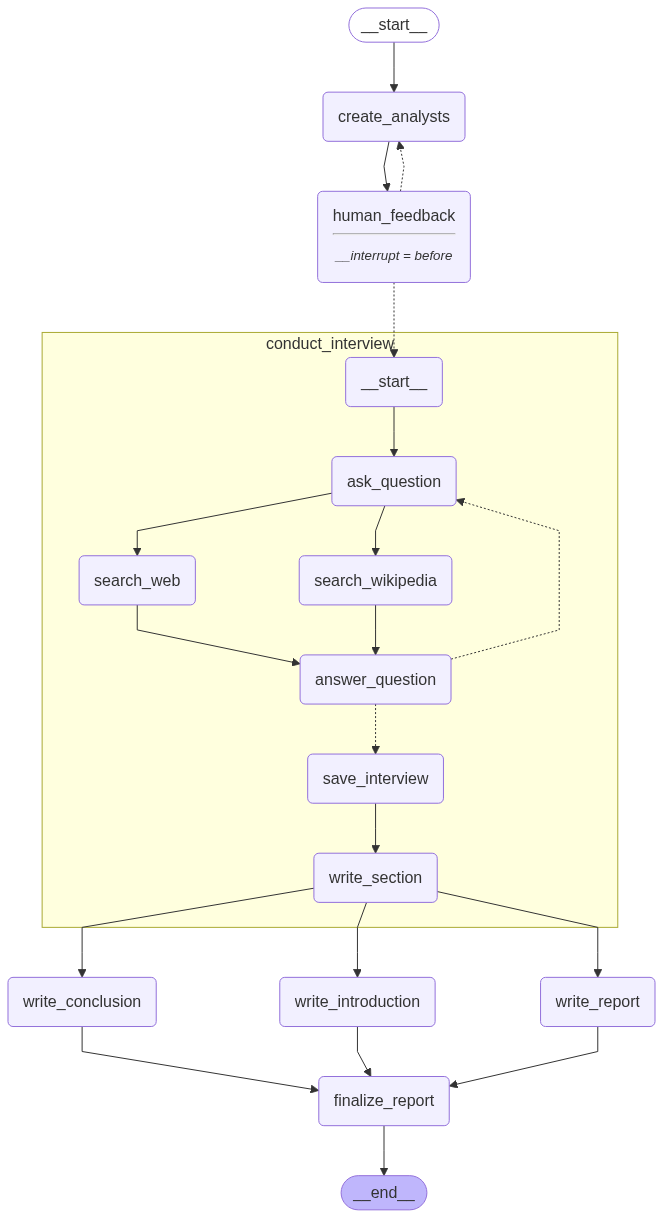

In [33]:
# Add nodes and edges 
builder = StateGraph(ResearchGraphState)
builder.add_node("create_analysts", create_analysts)
builder.add_node("human_feedback", human_feedback)
builder.add_node("conduct_interview", interview_builder.compile())
builder.add_node("write_report",write_report)
builder.add_node("write_introduction",write_introduction)
builder.add_node("write_conclusion",write_conclusion)
builder.add_node("finalize_report",finalize_report)

# Logic
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", initiate_all_interviews, ["create_analysts", "conduct_interview"])
builder.add_edge("conduct_interview", "write_report")
builder.add_edge("conduct_interview", "write_introduction")
builder.add_edge("conduct_interview", "write_conclusion")
builder.add_edge(["write_conclusion", "write_report", "write_introduction"], "finalize_report")
builder.add_edge("finalize_report", END)

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [34]:
# Inputs
max_analysts = 2 
topic = "The benefits of adopting LangGraph as an agent framework"
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream({"topic":topic,
                           "max_analysts":max_analysts}, 
                          thread, 
                          stream_mode="values"):
    
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Ada Sterling
Affiliation: Global Ethics Institute
Role: AI Ethics Specialist
Description: Dr. Sterling focuses on the ethical implications of AI frameworks, particularly how LangGraph can ensure fairness, transparency, and accountability in AI decision-making processes. She is concerned about potential biases and advocates for regulations that promote ethical AI adoption.
--------------------------------------------------
Name: Alex Chen
Affiliation: Tech Innovators Consortium
Role: AI Integration Specialist
Description: Alex Chen specializes in the technical integration of AI frameworks within existing systems. He is interested in how LangGraph can enhance interoperability, scalability, and efficiency in AI applications. Alex is motivated by the potential for LangGraph to revolutionize industries through seamless AI integration.
--------------------------------------------------


In [35]:
# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"human_analyst_feedback": 
                                "Add in the CEO of gen ai native startup"}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f040e23-834c-6656-8002-491e5d2d82c1'}}

In [36]:
# Check
for event in graph.stream(None, thread, stream_mode="values"):
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

Name: Dr. Ada Sterling
Affiliation: Global Ethics Institute
Role: AI Ethics Specialist
Description: Dr. Sterling focuses on the ethical implications of AI frameworks, particularly how LangGraph can ensure fairness, transparency, and accountability in AI decision-making processes. She is concerned about potential biases and advocates for regulations that promote ethical AI adoption.
--------------------------------------------------
Name: Alex Chen
Affiliation: Tech Innovators Consortium
Role: AI Integration Specialist
Description: Alex Chen specializes in the technical integration of AI frameworks within existing systems. He is interested in how LangGraph can enhance interoperability, scalability, and efficiency in AI applications. Alex is motivated by the potential for LangGraph to revolutionize industries through seamless AI integration.
--------------------------------------------------
Name: Dr. Ada Sterling
Affiliation: Global AI Ethics Institute
Role: AI Ethics and Policy Special

In [37]:
# Confirm we are happy
graph.update_state(thread, {"human_analyst_feedback": 
                            None}, as_node="human_feedback")

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f040e23-d1d3-6b82-8004-2ccb74613d5e'}}

In [38]:
# Continue
for event in graph.stream(None, thread, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

--Node--
conduct_interview
--Node--
conduct_interview
--Node--
write_report
--Node--
write_conclusion
--Node--
write_introduction
--Node--
finalize_report


In [39]:
from IPython.display import Markdown
final_state = graph.get_state(thread)
report = final_state.values.get('final_report')
Markdown(report)

# LangGraph: The Next Frontier in AI Agent Development

## Introduction

LangGraph, an innovative open-source library within the LangChain ecosystem, is transforming the landscape of AI agent development. By facilitating the creation of stateful, multi-actor applications powered by Large Language Models (LLMs), LangGraph enables sophisticated agent runtimes that adapt to changing conditions. Unlike fully autonomous frameworks, LangGraph offers controlled orchestration within predefined boundaries, ensuring ethical control and predictability. Its graph-based architecture provides a visual and organized method for managing workflows, making it scalable and versatile for real-world applications. This report explores the benefits of adopting LangGraph, including enhanced control, simplified development, and seamless integration with external tools, highlighting its potential to revolutionize AI agent frameworks.

---



LangGraph is an open-source library within the LangChain ecosystem designed for constructing stateful, multi-actor applications powered by Large Language Models (LLMs) [2]. It distinguishes itself through a graph-based architecture that provides developers with enhanced control, predictability, and scalability in AI agent development [2]. This framework facilitates the creation and management of cyclical graphs, enabling sophisticated agent runtimes where agents can revisit previous steps and adapt to changing conditions [2].

Unlike fully autonomous agentic frameworks such as AutoGPT and BabyAGI, LangGraph requires developers to explicitly define all possible execution paths, offering a more controlled orchestration within predefined boundaries [1]. This structured approach allows programmers to easily know in advance where the information/states will flow [3]. The graph-based architecture allows for precise visualization, debugging, and optimization of agent workflows, making it particularly valuable for creating multi-agent systems and Retrieval Augmented Generation (RAG) applications [2, 3].

LangGraph simplifies the development process by abstracting complexities related to state management, agent coordination, and error handling [1, 3]. This abstraction allows developers to focus on creating intelligent and responsive AI agents without being overwhelmed by the intricacies of managing complex workflows [3]. The ability to easily integrate external APIs further extends an agent’s functionality, enabling access to real-time data for dynamic interactions [1].

LangGraph's stateful design allows agents to maintain context across interactions, adapting to advanced use cases such as risk profiling and sentiment-driven alerts [6]. Its modular design supports the integration of new tools and the expansion of nodes, demonstrating its scalability and reliability [6]. To ensure scalability, LangGraph supports horizontal scaling, distributing workloads across multiple nodes [5].

To begin using LangGraph, one can install the Langgraph CLI and build Docker images of applications [4]. This framework models complex conversational flows, manages state, and integrates external tools and APIs seamlessly, making it versatile for real-world use cases, from personal assistants to privacy-focused agents [6].

While LangGraph offers significant advantages, it's important to consider whether its advanced capabilities are necessary for all use cases [7]. Simpler systems might suffice for less complex applications, making it crucial to evaluate the cost-benefit of adopting LangGraph [7]. As AI ethics evolves, LangGraph is expected to incorporate more robust mechanisms for fairness, accountability, and transparency, including bias detection and mitigation tools, and enhanced auditing capabilities [5].


---

## Conclusion

In conclusion, LangGraph presents a compelling framework for developing sophisticated AI agents, offering a balance between control and advanced functionality. This report has explored how LangGraph's graph-based architecture facilitates predictable workflow management and simplifies the complexities of state handling and agent coordination. We've highlighted its advantages in simplifying development, enhancing control, and enabling scalability, particularly in multi-agent and RAG applications. While LangGraph's advanced capabilities may not be necessary for all use cases, its modular design and integration with external APIs make it a versatile tool for building intelligent and responsive AI agents. As AI ethics and the need for robust mechanisms for fairness, accountability, and transparency evolve, LangGraph is expected to incorporate more robust mechanisms for these critical areas.

## Sources

[1] https://medium.com/@saeedhajebi/langgraph-is-not-a-true-agentic-framework-3f010c780857
[2] https://www.turing.com/resources/ai-agent-frameworks
[3] https://www.reddit.com/r/LangChain/comments/1j4714z/langgraph_vs_other_ai_agents_frameworks/
[4] https://medium.com/mitb-for-all/a-gentle-introduction-to-the-llm-multi-agents-multiverse-part-1-langgraph-2ac56f1b5b3c
[5] https://ragaboutit.com/mastering-langgraph-a-production-ready-coding-walkthrough-for-software-engineers/
[6] https://github.com/cris-m/langgraph_examples
[7] https://medium.com/@julian.burns50/langgraph-a-tool-from-the-future-or-a-step-function-to-complexity-2535e73ebf26
[8] https://www.linkedin.com/pulse/how-build-custom-ai-agent-using-langgraph-framework-stafeeka-r-4uiie
[9] https://medium.com/@vikaskumarsingh_60821/langgraph-the-future-of-production-grade-ai-agent-architectures-623d68dbbfb6
[10] https://medium.com/@pankaj_pandey/building-advanced-ai-agents-with-langgraph-enhancing-your-llm-applications-c43c6803a9d2